In [1]:
!pip install tslearn
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import yfinance as yf
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

from sklearn.decomposition import PCA

import scipy.cluster.hierarchy as hac
import dtaidistance
from dtaidistance import clustering, dtw
from sklearn.svm import OneClassSVM
from numpy import where

<ipython-input-2-52a36da0ece8>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject


Возьмём тикеры исключительно криптовалют. И данные 'Close' за 60 дней

In [3]:
crypto_list_first = ['BTC-USD','USDT-USD','USDC-USD','BNB-USD','XRP-USD','BUSD-USD', 'ADA-USD', 'SOL-USD','MATIC-USD','DOT-USD','DAI-USD', 'WTRX-USD','SHIB-USD','HEX-USD','TRX-USD','UNI1-USD','AVAX-USD',  'WBTC-USD', 'STETH-USD', 'YOUC-USD', 'LEO-USD', 'LTC-USD', 'ATOM-USD', 'LINK-USD']
crypto_list_second = ['FTT-USD', 'XLM-USD', 'CRO-USD', 'XMR-USD', 'ALGO-USD', 'NEAR-USD', 'BCH-USD', 'TON11419-USD', 'QNT-USD', 'FIL-USD', 'FLOW-USD', 'VET-USD', 'ICP-USD', 'LUNC-USD', 'CHZ-USD', 'EGLD-USD', 'HBAR-USD', 'HT-USD', 'APE18876-USD', 'OKB-USD', 'XTZ-USD', 'THETA-USD', 'SAND-USD']
crypto_list_third = ['FRAX-USD', 'MANA-USD', 'AAVE-USD', 'WBNB-USD', 'EOS-USD','XCN18679-USD', 'KCS-USD', 'APT21794-USD', 'USDP-USD', 'BSV-USD', 'BIT11221-USD', 'BTTOLD-USD', 'AXS-USD', 'MKR-USD', 'TUSD-USD', 'ZEC-USD', 'HBTC-USD', 'BTT-USD', 'SNX-USD', 'KLAY-USD', 'USDD-USD', 'XEC-USD', 'MIOTA-USD','CAKE-USD', 'FTM-USD']
list_all_tickers = [crypto_list_first, crypto_list_second, crypto_list_third]

In [4]:
crypto_first = pd.DataFrame(columns=crypto_list_first)
for ticker in crypto_list_first:
    crypto_first[ticker] = yf.download(ticker, start = '2022-09-01', end = '2022-10-30')['Close']

crypto_second = pd.DataFrame(columns=crypto_list_second)
for ticker in crypto_list_second:
    crypto_second[ticker] = yf.download(ticker, start = '2022-09-01', end = '2022-10-30')['Close']

crypto_third = pd.DataFrame(columns=crypto_list_third)
for ticker in crypto_list_third:
    crypto_third[ticker] = yf.download(ticker, start = '2022-09-01', end = '2022-10-30')['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
df_aux = [crypto_first.T, crypto_second.T, crypto_third.T]
merge_df = pd.concat(df_aux)

In [6]:
merge_df

Date       2022-09-01 00:00:00+00:00  2022-09-02 00:00:00+00:00  \
BTC-USD                 20127.140625               19969.771484   
USDT-USD                    1.000010                   1.000089   
USDC-USD                    0.999976                   1.000101   
BNB-USD                   278.417236                 277.416107   
XRP-USD                     0.333194                   0.331259   
...                              ...                        ...   
USDD-USD                    0.999599                   0.999573   
XEC-USD                     0.000046                   0.000046   
MIOTA-USD                   0.283886                   0.280740   
CAKE-USD                    3.967798                   3.976539   
FTM-USD                     0.272376                   0.269281   

Date       2022-09-03 00:00:00+00:00  2022-09-04 00:00:00+00:00  \
BTC-USD                 19832.087891               19986.712891   
USDT-USD                    1.000074                   1.000061   
USDC-USD                    1.000126                   1.000107   
BNB-USD                   277.775574                 278.841858   
XRP-USD                     0.329969                   0.331799   
...                              ...                        ...   
USDD-USD                    0.999379                   0.999859   
XEC-USD                     0.000045                   0.000044   
MIOTA-USD                   0.280142                   0.290565   
CAKE-USD                    4.019826                   4.124890   
FTM-USD                     0.267172                   0.272934   

Date       2022-09-05 00:00:00+00:00  2022-09-06 00:00:00+00:00  \
BTC-USD                 19812.371094               18837.667969   
USDT-USD                    1.000038                   1.000049   
USDC-USD                    0.999882                   0.999878   
BNB-USD                   276.685913                 262.668396   
XRP-USD                     0.332960                   0.322208   
...                              ...                        ...   
USDD-USD                    0.999594                   0.998389   
XEC-USD                     0.000044                   0.000041   
MIOTA-USD                   0.281917                   0.260208   
CAKE-USD                    4.153072                   3.916922   
FTM-USD                     0.264406                   0.244736   

Date       2022-09-07 00:00:00+00:00  2022-09-08 00:00:00+00:00  \
BTC-USD                 19290.324219               19329.833984   
USDT-USD                    1.000109                   1.000102   
USDC-USD                    0.999993                   0.999914   
BNB-USD                   278.761322                 280.577484   
XRP-USD                     0.337367                   0.340245   
...                              ...                        ...   
USDD-USD                    0.998709                   0.998617   
XEC-USD                     0.000042                   0.000042   
MIOTA-USD                   0.276539                   0.279300   
CAKE-USD                    4.114633                   4.073327   
FTM-USD                     0.253574                   0.253109   

Date       2022-09-09 00:00:00+00:00  2022-09-10 00:00:00+00:00  ...  \
BTC-USD                 21381.152344               21680.539062  ...   
USDT-USD                    1.000235                   1.000281  ...   
USDC-USD                    0.999945                   0.999863  ...   
BNB-USD                   293.407135                 296.969055  ...   
XRP-USD                     0.357517                   0.357681  ...   
...                              ...                        ...  ...   
USDD-USD                    0.998985                   0.999306  ...   
XEC-USD                     0.000045                   0.000045  ...   
MIOTA-USD                   0.292148                   0.295642  ...   
CAKE-USD                    4.321973                   4.346

In [7]:
merge_df.columns = merge_df.columns.strftime('%m/%d/%Y')

In [8]:
merge_df[merge_df.isnull().any(1)]

Date          09/01/2022  09/02/2022  09/03/2022  09/04/2022  09/05/2022  \
UNI1-USD        6.320145    6.401448    6.303452    6.469304    6.589822   
APT21794-USD         NaN         NaN         NaN         NaN         NaN   

Date          09/06/2022  09/07/2022  09/08/2022  09/09/2022  09/10/2022  ...  \
UNI1-USD        5.848081    6.122471     6.17205    6.507528    6.675907  ...   
APT21794-USD         NaN         NaN         NaN         NaN         NaN  ...   

Date          10/20/2022  10/21/2022  10/22/2022  10/23/2022  10/24/2022  \
UNI1-USD             NaN         NaN         NaN         NaN         NaN   
APT21794-USD    7.360025    7.495839    8.933971    9.768685    9.530889   

Date          10/25/2022  10/26/2022  10/27/2022  10/28/2022  10/29/2022  
UNI1-USD             NaN         NaN         NaN         NaN         NaN  
APT21794-USD    8.794205    9.195348    8.699895    8.166599     7.95161  

[2 rows x 59 columns]

Всего 2 тикера с NaN. И NaN не единичные. Данные тикеры лучше просто удалить

In [9]:
merge_df['shortName'] = merge_df.index

In [10]:
merge_df.dropna(how='any', axis=0, inplace = True)

In [11]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(merge_df.iloc[:,:-1].T).T

In [12]:
tickers_scaled

array([[ 0.56928188,  0.36055242,  0.17793324, ...,  0.77977034,
         1.1903021 ,  1.48624807],
       [-0.93567744,  0.07594192, -0.11631153, ...,  0.11408745,
         0.8052844 ,  1.82911033],
       [-0.39910487,  1.26925516,  1.60340453, ..., -0.49218934,
        -1.10638769,  0.97647667],
       ...,
       [ 0.84686996,  0.66211359,  0.62699549, ..., -1.06236091,
        -0.78640074, -0.65673069],
       [-2.04496359, -2.00548886, -1.81000053, ...,  0.11950015,
         0.53910466,  0.9275338 ],
       [ 1.91880168,  1.7784653 ,  1.68283749, ..., -0.60040527,
        -0.21589744, -0.20850705]])

In [13]:
data_scaled_df = pd.DataFrame(tickers_scaled, index = merge_df.shortName, columns = merge_df.columns[:-1] )

### Работа с аномалиями 

In [14]:
data_scaled_df_new = pd.DataFrame(index = merge_df.shortName, columns = merge_df.columns[:-1])

<ipython-input-15-87effaebe16b>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


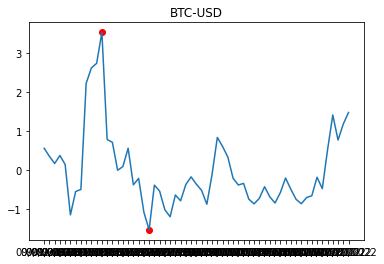

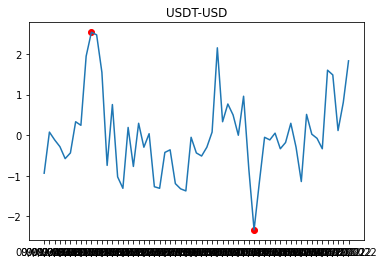

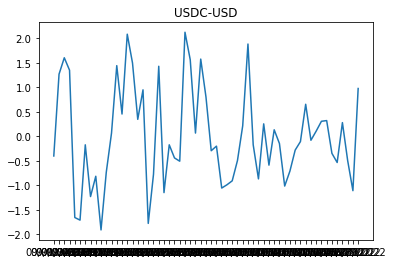

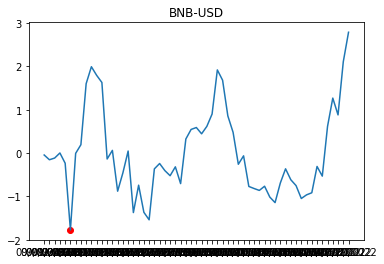

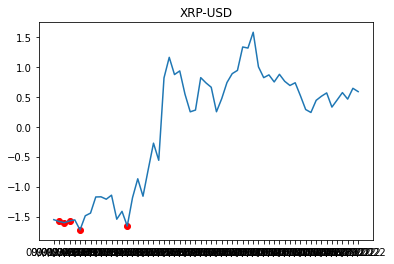

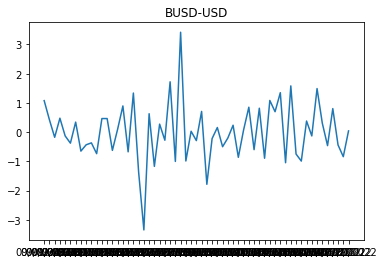

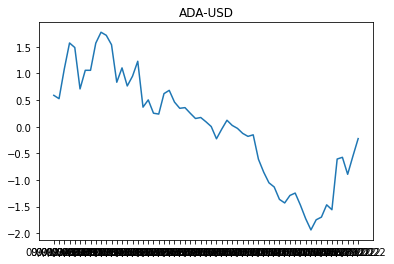

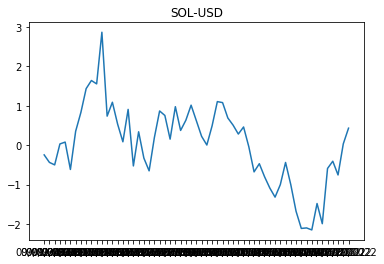

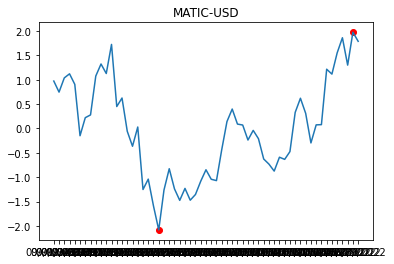

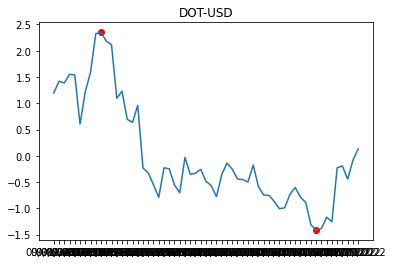

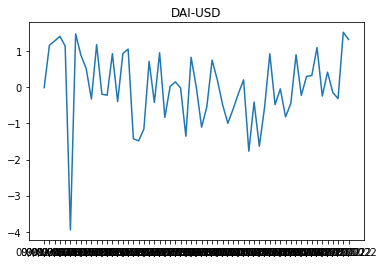

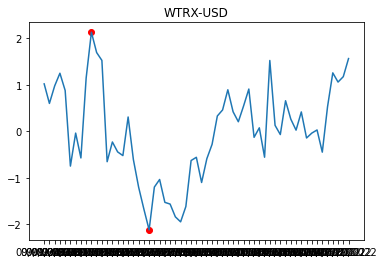

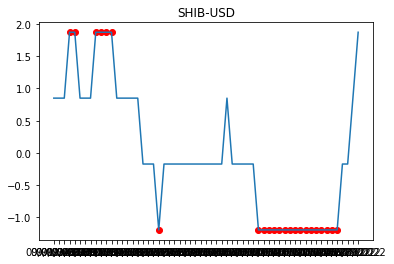

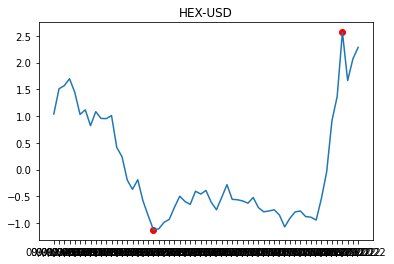

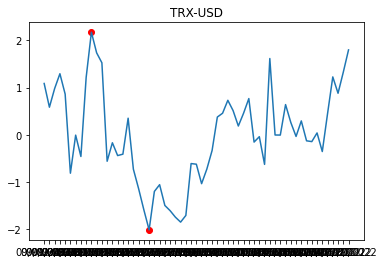

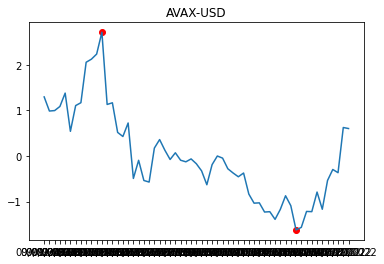

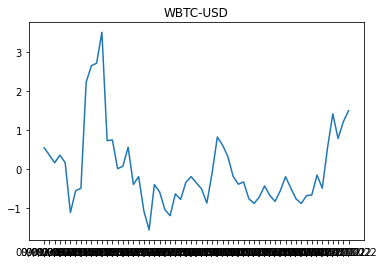

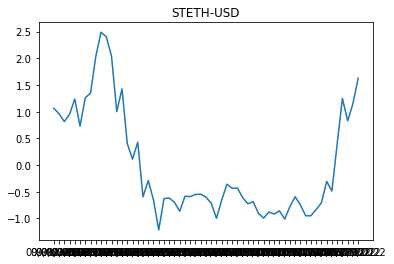

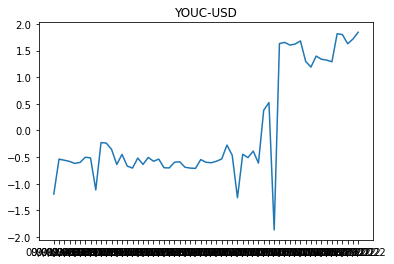

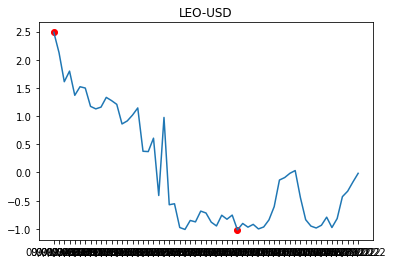

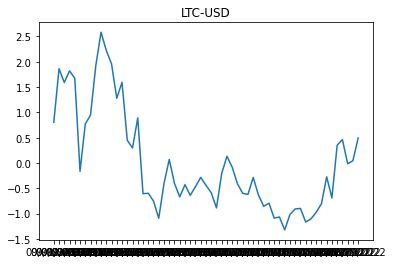

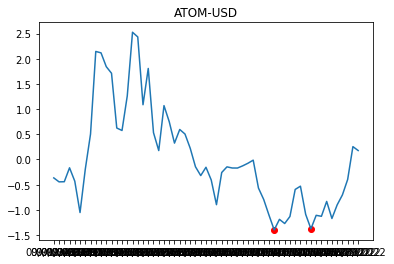

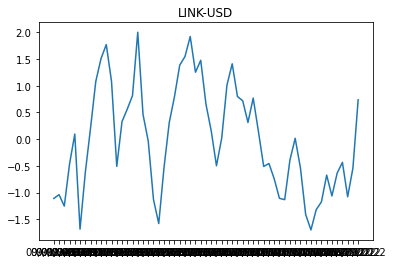

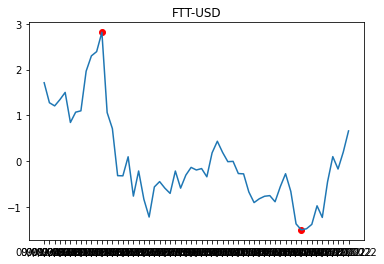

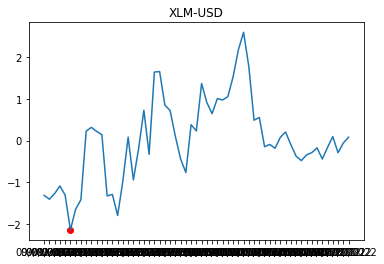

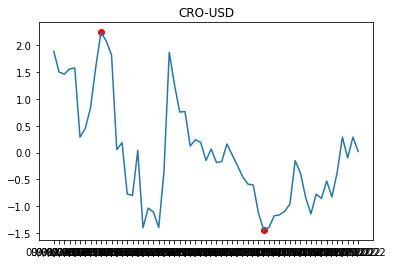

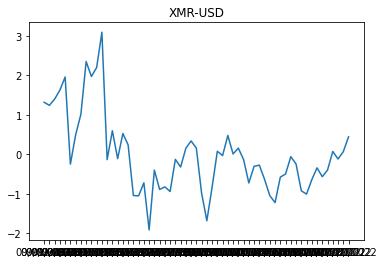

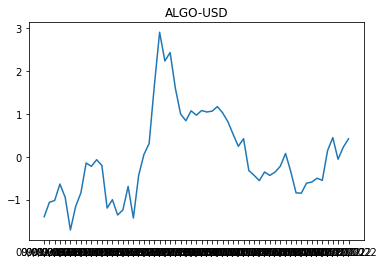

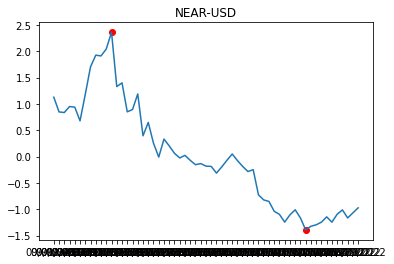

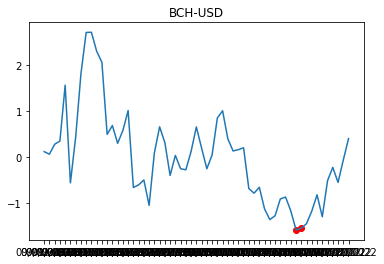

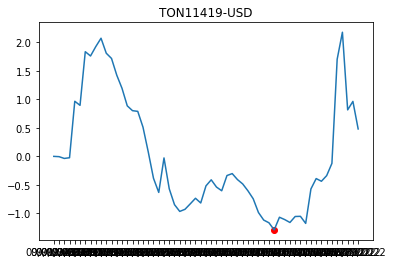

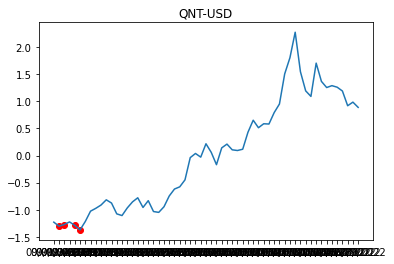

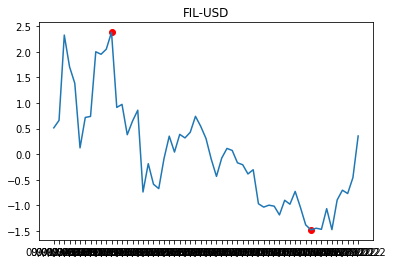

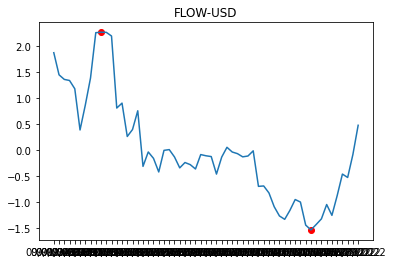

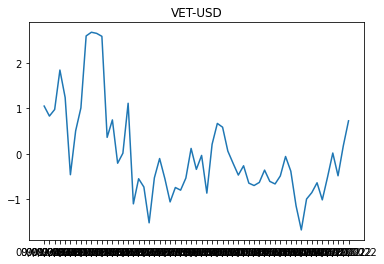

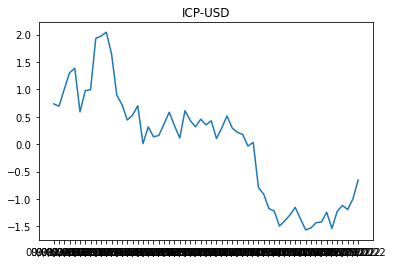

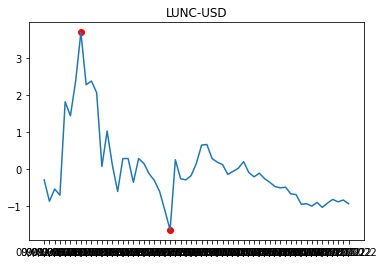

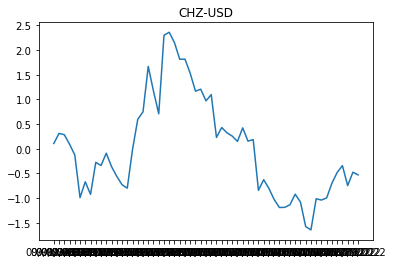

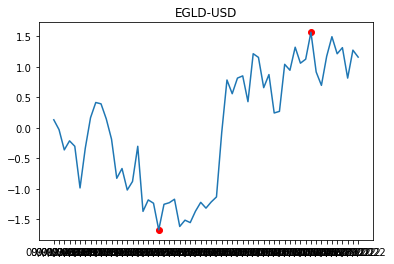

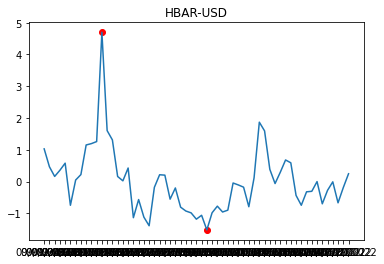

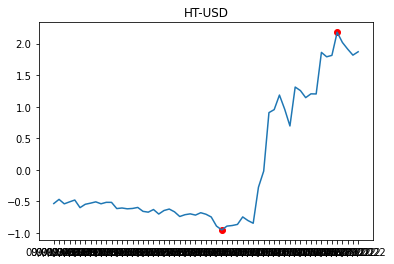

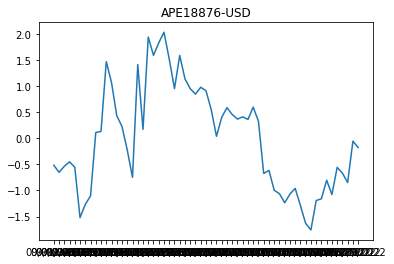

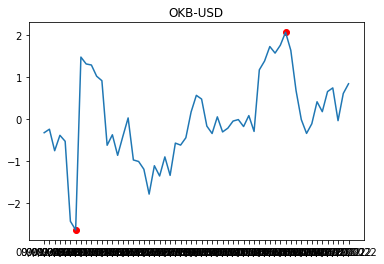

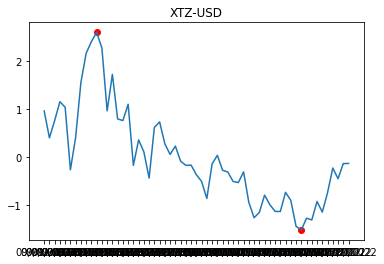

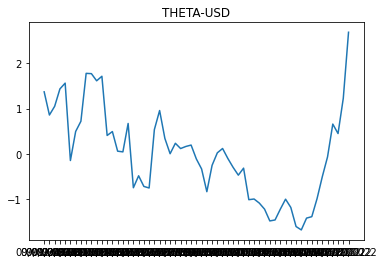

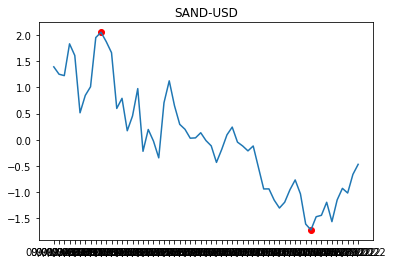

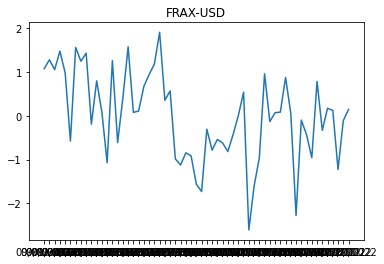

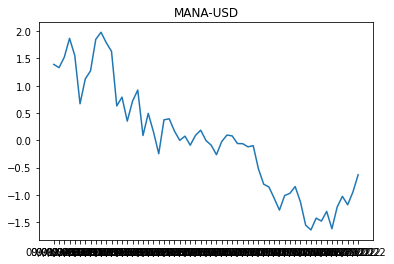

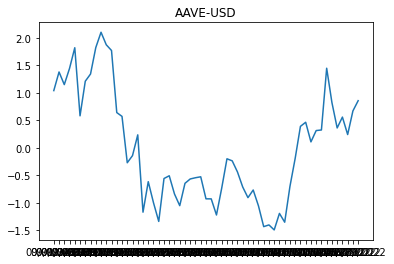

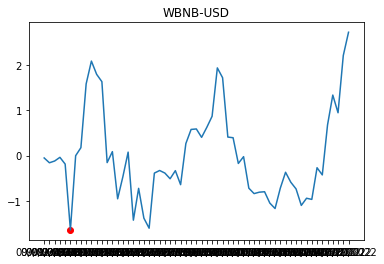

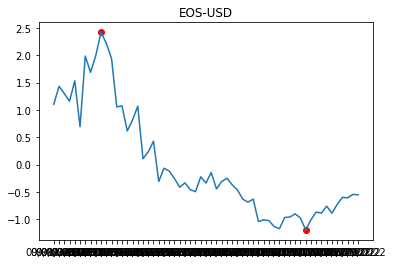

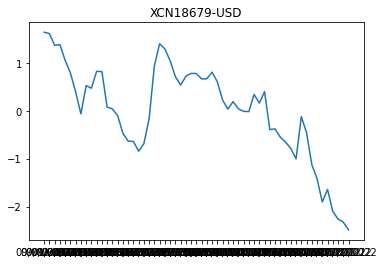

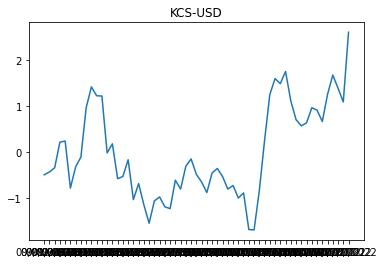

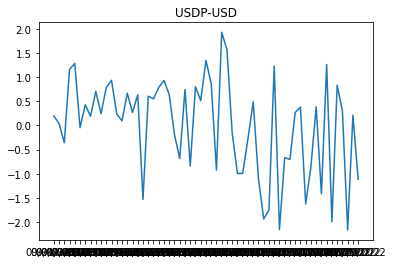

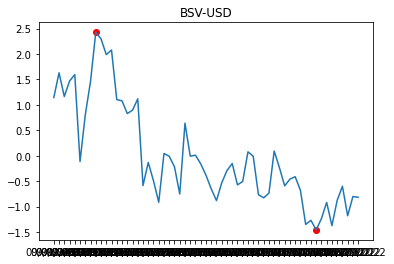

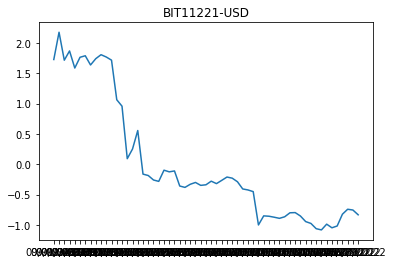

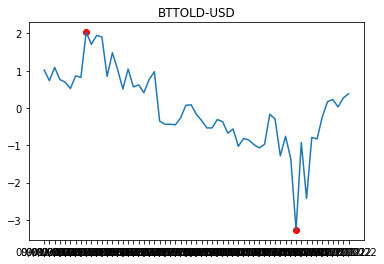

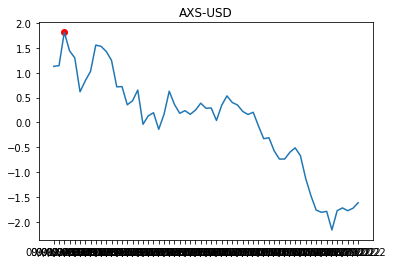

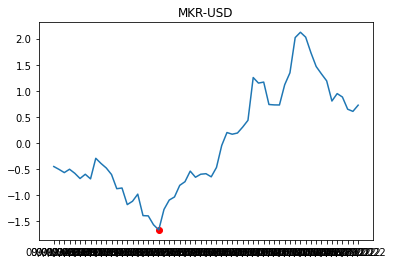

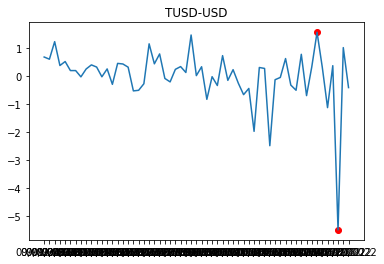

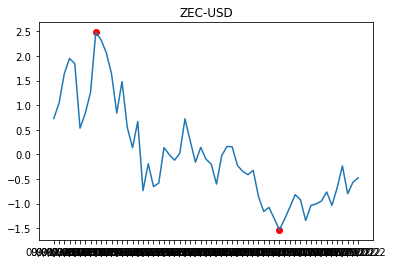

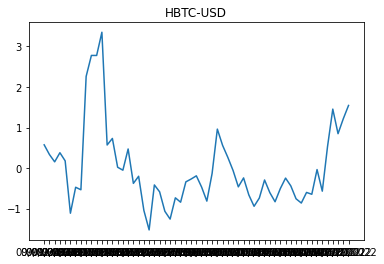

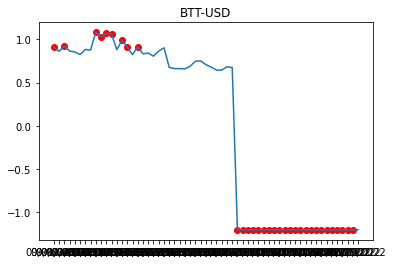

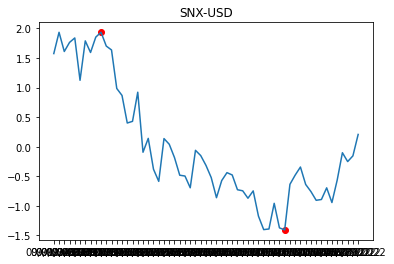

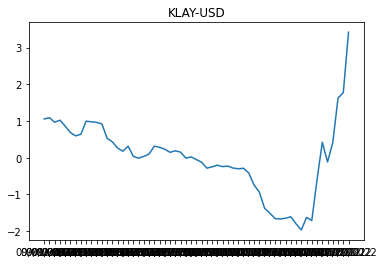

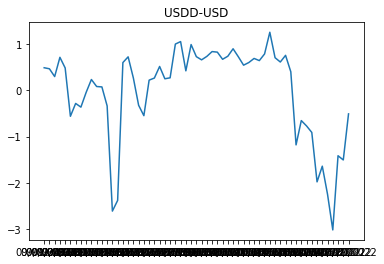

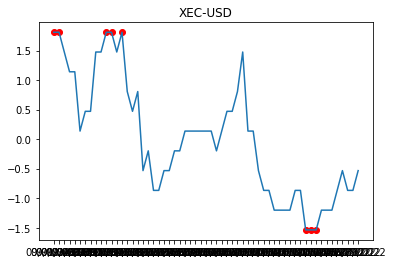

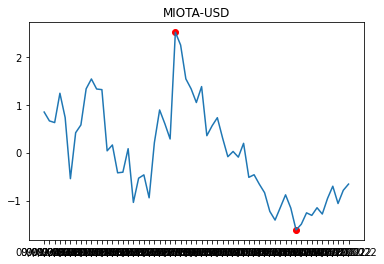

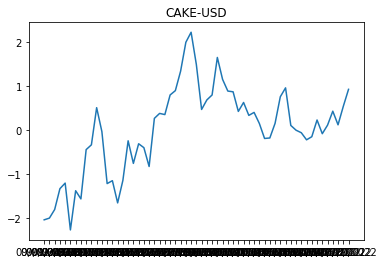

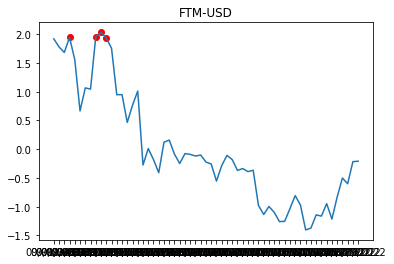

In [15]:
for i in range(data_scaled_df.shape[0]):
    model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.03).fit(pd.DataFrame(data_scaled_df.iloc[i,:].T))
    y_pred = model.predict(pd.DataFrame(data_scaled_df.iloc[i,:-1].T))

    outlier_index = where(y_pred == -1) 
    outlier_values = pd.DataFrame(data_scaled_df.iloc[i,:].T).iloc[outlier_index]

    #Визуализируем найденные аномалии
    fig, ax = plt.subplots()
    plt.plot(data_scaled_df.iloc[i,:])
    plt.scatter(outlier_values.index, outlier_values.values, c = "r")
    plt.title(data_scaled_df.index[i])
    aux = [int(x) for x in outlier_index[0]]

    for j in range(len(aux)):
        if aux[j] == 0:
            data_scaled_df_new.iloc[i, aux[j]] = data_scaled_df.iloc[i, aux[j]+1]
        elif aux[j] == data_scaled_df.shape[1]-1:
            data_scaled_df_new.iloc[i, aux[j]] = data_scaled_df.iloc[i, aux[j]-1]
        else:
            data_scaled_df_new.iloc[i, aux[j]] = (data_scaled_df.iloc[i, aux[j]+1]+data_scaled_df.iloc[i, aux[j]-1])/2
            data_scaled_df.iat[i, aux[j]] = 0.0

In [16]:
data_scaled_df_new.fillna(0, inplace = True)

In [19]:
data_scaled_df = pd.DataFrame(data_scaled_df_new.add(data_scaled_df))

### Иерархическая кластеризация 

In [20]:
model = clustering.HierarchicalTree(dists_fun=dtw.distance_matrix_fast, dists_options={})
cluster_idx = model.fit(data_scaled_df.values)

DTAIDistance C-extension for Numpy is not available. Proceeding anyway.
  0%|          | 0/70 [00:00<?, ?it/s]

 99%|█████████▊| 69/70 [00:00<00:00, 3001.15it/s]


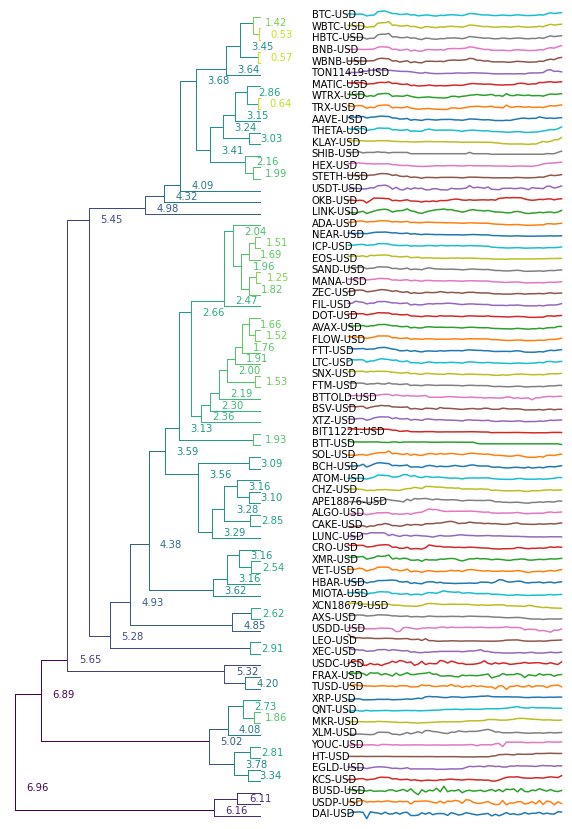

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
show_ts_label = lambda idx: data_scaled_df.index[idx]
model.plot(axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)
plt.show()

### DTW

  0%|          | 0/8 [00:00<?, ?it/s]

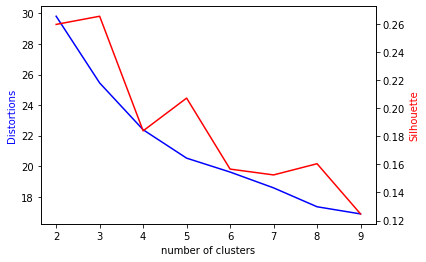

In [22]:
distortions = []
silhouette = []
K = range(2,10)
for k in tqdm(K):
  kmeanModel = TimeSeriesKMeans(n_clusters = k, metric = 'euclidean', n_jobs = 6, max_iter = 10, n_init = 5)
  kmeanModel.fit(tickers_scaled)
  distortions.append(kmeanModel.inertia_)
  silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric = 'euclidean'))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('number of clusters')
ax1.set_ylabel('Distortions', color = 'b')
ax2.set_ylabel('Silhouette', color = 'r')

plt.show()

Маленькие значения силуэта при всех n, что плохо

In [23]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'dtw', n_jobs = 6, max_iter = 10)
ts_kmeans.fit(data_scaled_df)
for n in range(n_clusters):
    print(data_scaled_df.index[ts_kmeans.labels_==n])

Index(['BTC-USD', 'USDT-USD', 'USDC-USD', 'BNB-USD', 'SOL-USD', 'WBTC-USD',
       'ATOM-USD', 'LINK-USD', 'BCH-USD', 'TON11419-USD', 'LUNC-USD',
       'CHZ-USD', 'XTZ-USD', 'WBNB-USD', 'XCN18679-USD', 'AXS-USD', 'HBTC-USD',
       'USDD-USD', 'MIOTA-USD'],
      dtype='object', name='shortName')
Index(['XRP-USD', 'XLM-USD', 'ALGO-USD', 'APE18876-USD', 'OKB-USD',
       'CAKE-USD'],
      dtype='object', name='shortName')
Index(['ADA-USD', 'MATIC-USD', 'DOT-USD', 'DAI-USD', 'WTRX-USD', 'SHIB-USD',
       'HEX-USD', 'TRX-USD', 'AVAX-USD', 'STETH-USD', 'LEO-USD', 'LTC-USD',
       'FTT-USD', 'CRO-USD', 'XMR-USD', 'NEAR-USD', 'FIL-USD', 'FLOW-USD',
       'VET-USD', 'ICP-USD', 'HBAR-USD', 'THETA-USD', 'SAND-USD', 'FRAX-USD',
       'MANA-USD', 'AAVE-USD', 'EOS-USD', 'BSV-USD', 'BIT11221-USD',
       'BTTOLD-USD', 'TUSD-USD', 'ZEC-USD', 'BTT-USD', 'SNX-USD', 'KLAY-USD',
       'XEC-USD', 'FTM-USD'],
      dtype='object', name='shortName')
Index(['YOUC-USD', 'QNT-USD', 'EGLD-USD', 'HT-USD'

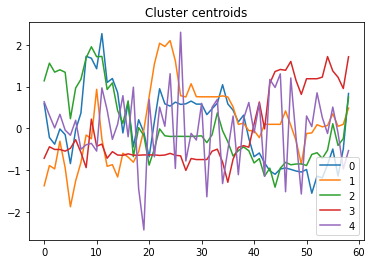

In [24]:
for cluster_number in range (n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label = cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

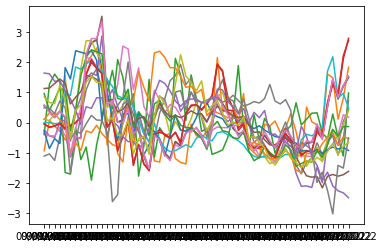

In [25]:
for item in data_scaled_df.index[ts_kmeans.labels_== 0].values.tolist():
    plt.plot(data_scaled_df.columns.values, data_scaled_df.loc[item].values.T)

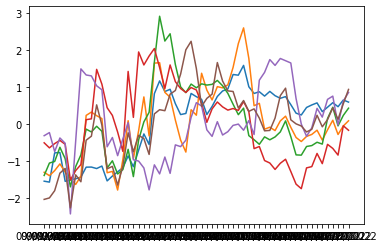

In [26]:
for item in data_scaled_df.index[ts_kmeans.labels_== 1].values.tolist():
    plt.plot(data_scaled_df.columns.values, data_scaled_df.loc[item].values.T)

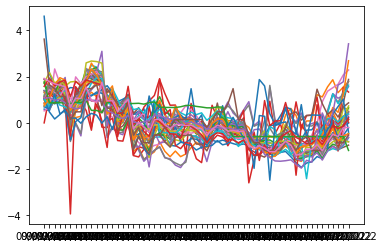

In [27]:
for item in data_scaled_df.index[ts_kmeans.labels_== 2].values.tolist():
    plt.plot(data_scaled_df.columns.values, data_scaled_df.loc[item].values.T)

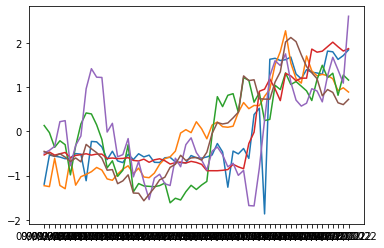

In [28]:
for item in data_scaled_df.index[ts_kmeans.labels_== 3].values.tolist():
    plt.plot(data_scaled_df.columns.values, data_scaled_df.loc[item].values.T)

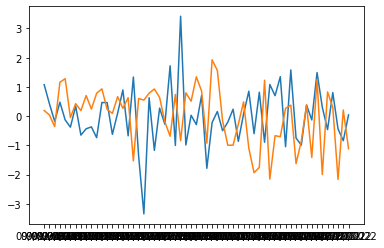

In [29]:
for item in data_scaled_df.index[ts_kmeans.labels_== 4].values.tolist():
    plt.plot(data_scaled_df.columns.values, data_scaled_df.loc[item].values.T)

In [30]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(int(np.ceil(current_cluster.shape[0]/4)), \
                           4, figsize = (15, 3*int(np.ceil(current_cluster.shape[0]/4))))
    fig.autofmt_xdate(rotation = 45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[:-2])
        ax[index].set_title(f'{row.shortName}\n')
        plt.xticks(rotation = 45)

    plt.tight_layout()
    plt.show()

In [31]:
data_scaled_df['shortName'] = data_scaled_df.index
data_scaled_df['cluster'] = ts_kmeans.predict(tickers_scaled)

C:\Users\USER\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 70 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


Cluster number0
------------------------------------------------------



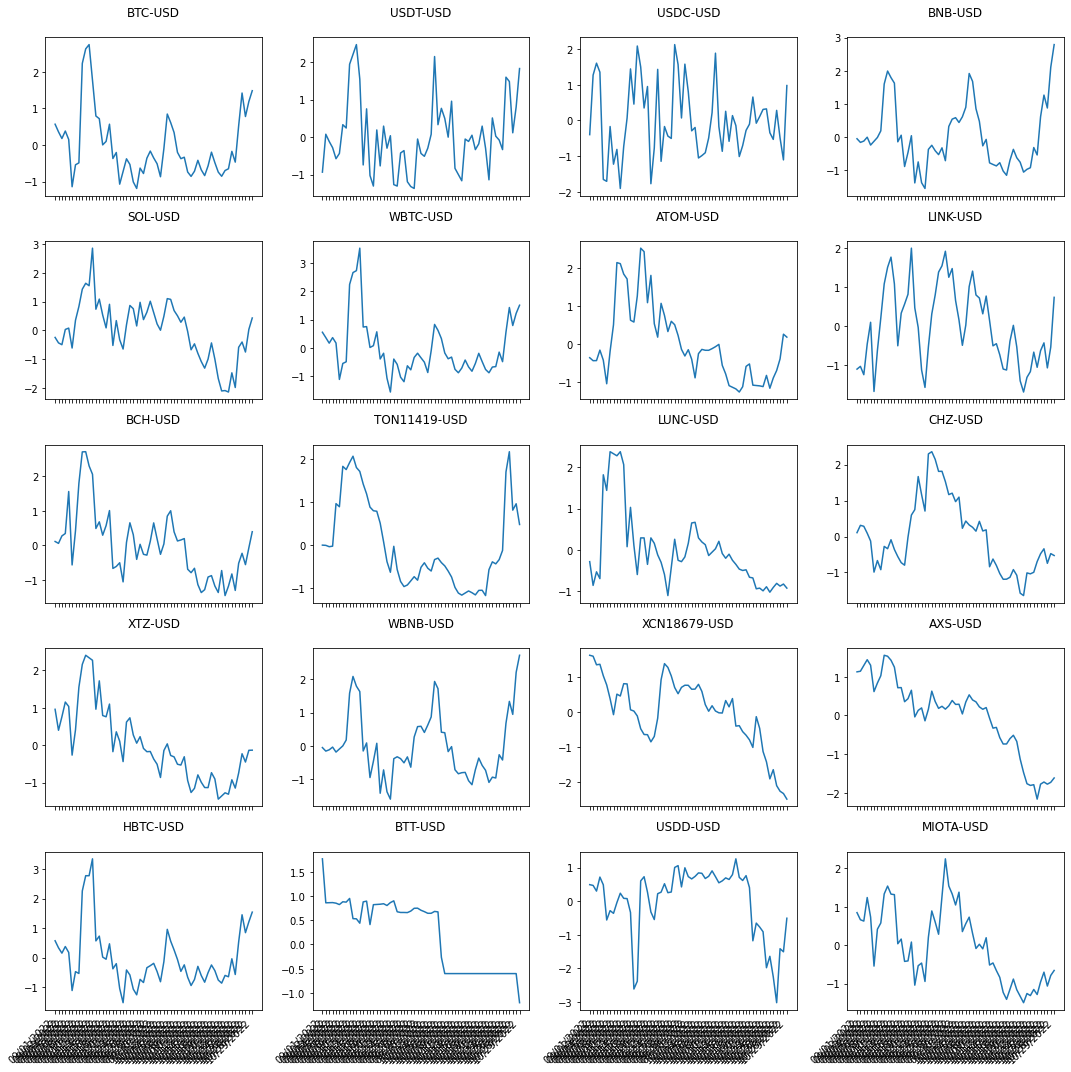

Cluster number1
------------------------------------------------------



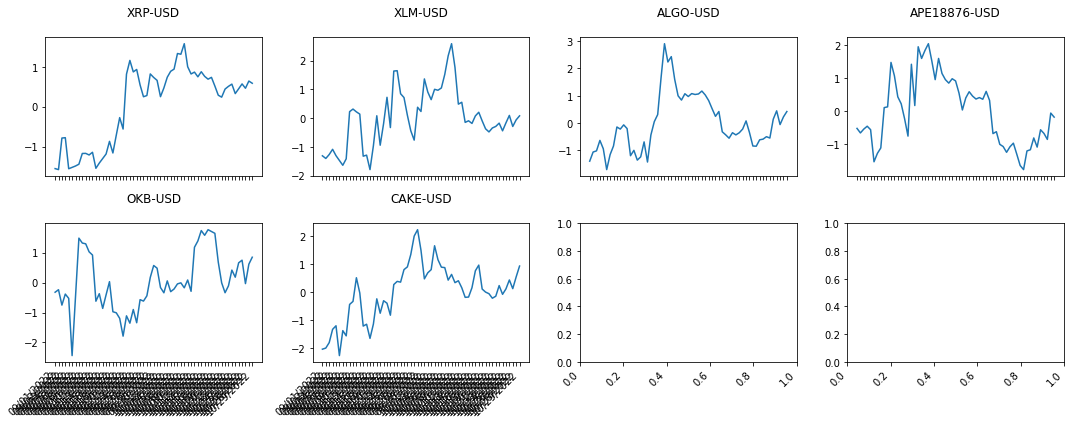

Cluster number2
------------------------------------------------------



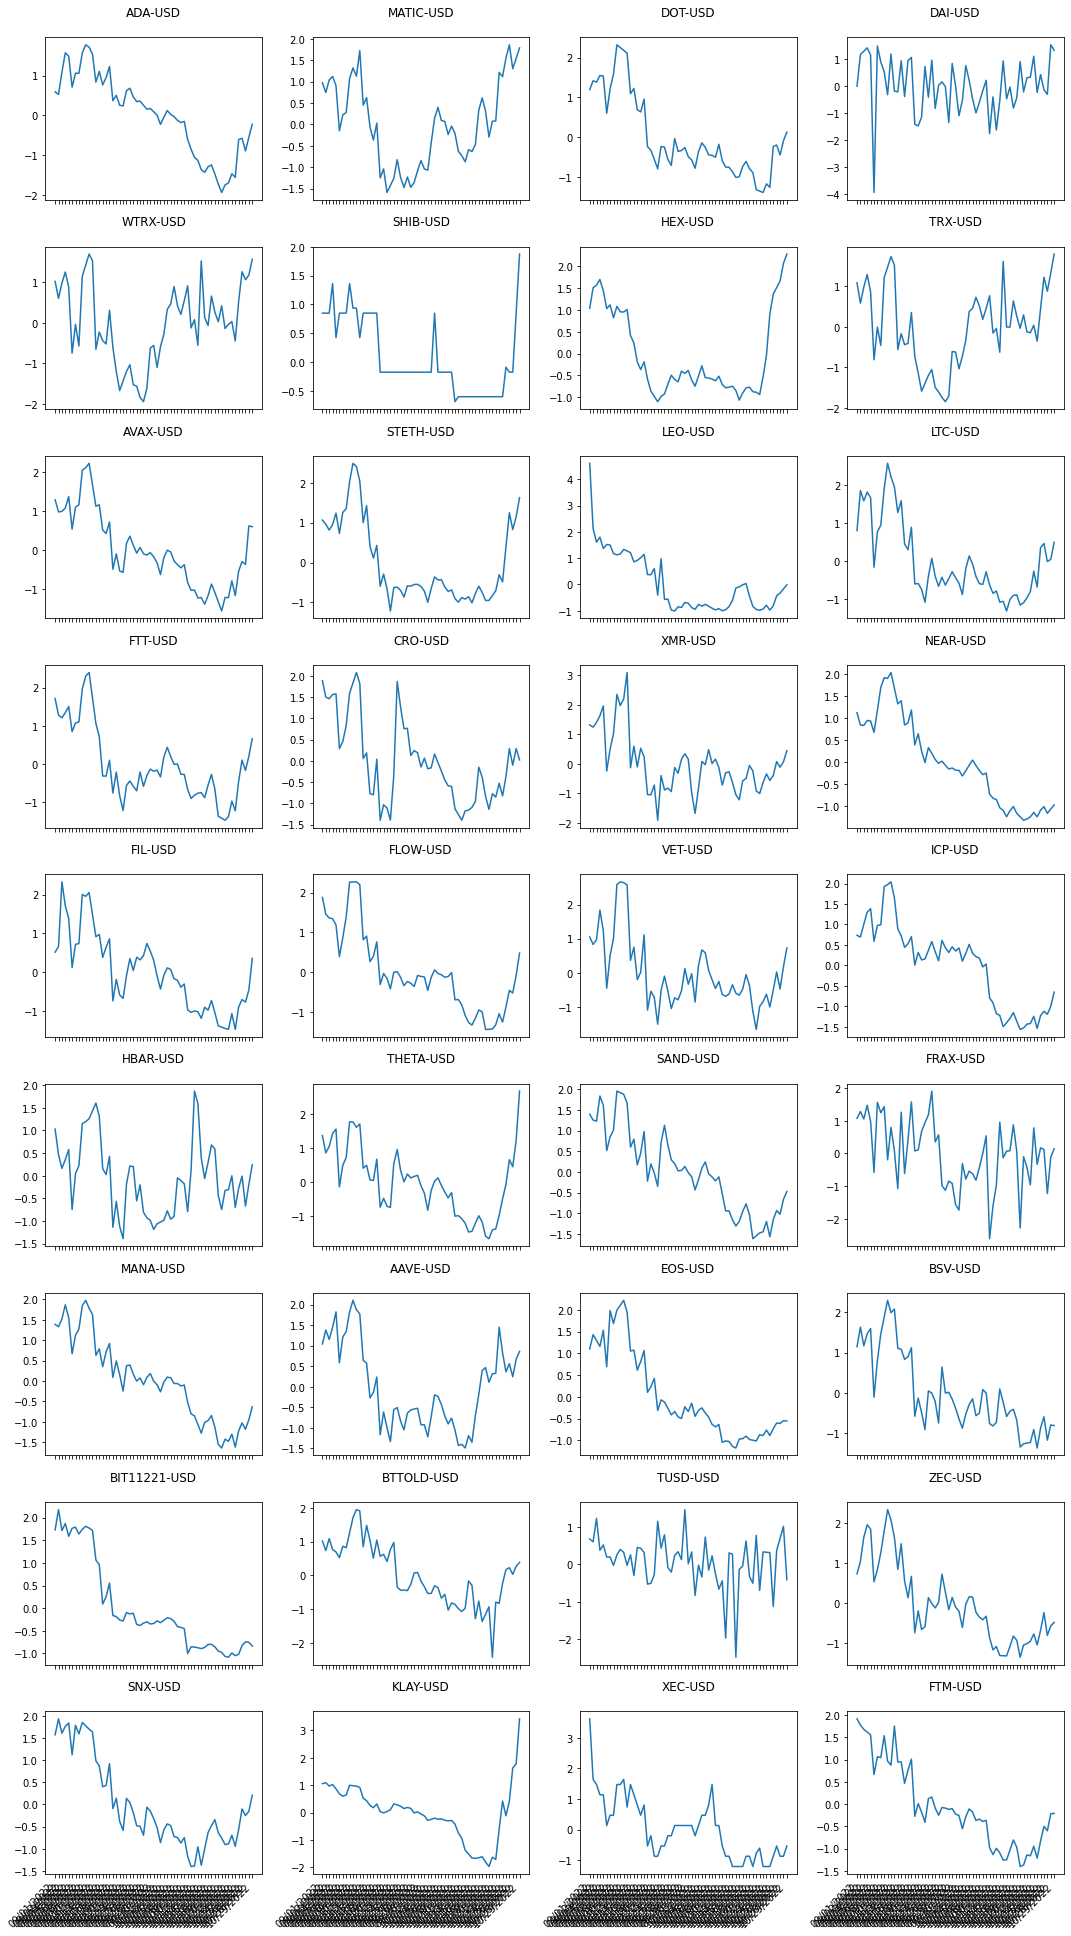

Cluster number3
------------------------------------------------------



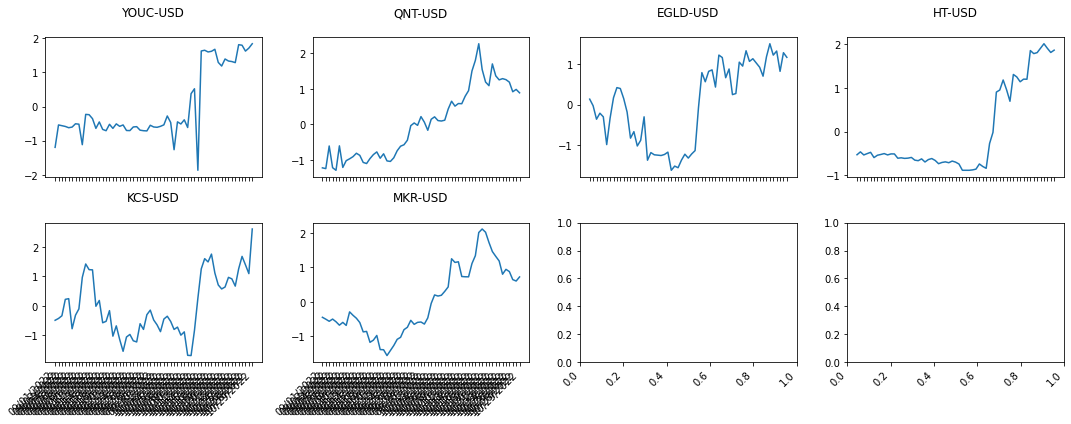

Cluster number4
------------------------------------------------------



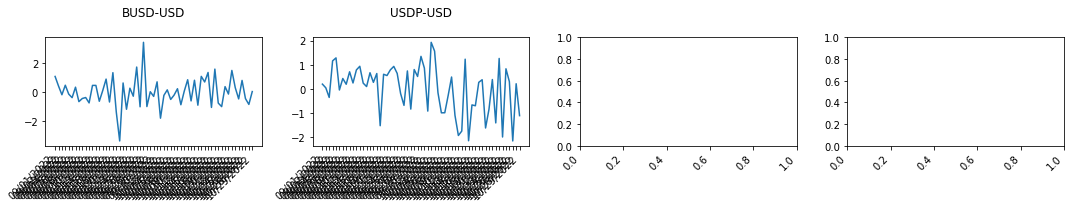

In [32]:
for cluster in range(n_clusters):
    print(f"Cluster number{cluster}")
    print("------------------------------------------------------\n")
    plot_cluster_tickers(data_scaled_df[data_scaled_df.cluster == cluster])

### Feature extraction

In [33]:
id_array = np.arange(data_scaled_df.shape[0]).repeat(data_scaled_df.shape[1]-2)
time_array = np.tile(pd.to_datetime(data_scaled_df.columns[:-2].values), data_scaled_df.shape[0])
close_array = data_scaled_df.iloc[:,:-2].values.flatten()

In [34]:
data_for_feature = pd.DataFrame({'id': id_array, 'time':time_array, 'close': close_array})

In [35]:
efficient_fcp = settings.EfficientFCParameters()
minimal_fcp = settings.MinimalFCParameters()

In [36]:
efficient_matrix = extract_features(data_for_feature, column_id='id',column_sort = 'time',  impute_function=impute, default_fc_parameters=efficient_fcp)
minimal_matrix = extract_features(data_for_feature, column_id='id', column_sort = 'time', impute_function=impute, default_fc_parameters=minimal_fcp)

Feature Extraction: 100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


In [37]:
efficient_matrix = efficient_matrix.dropna(axis=1)
minimal_matrix = minimal_matrix.dropna(axis=1)

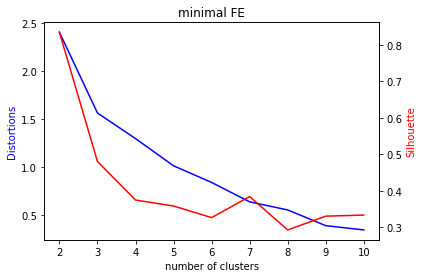

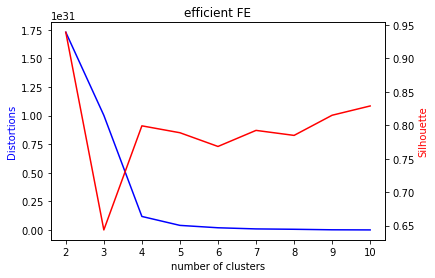

In [38]:
K = range(2,11)
for matrix, title in zip([minimal_matrix, efficient_matrix], ['minimal FE', 'efficient FE']):
    silhouette = []
    distortions = []
    for k in K:
        kmeanModel = TimeSeriesKMeans(n_clusters = k)
        kmeanModel.fit(matrix)
        distortions.append(kmeanModel.inertia_)
        silhouette.append(silhouette_score(matrix, kmeanModel.labels_, metric="euclidean"))
            
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(K, distortions, 'b-')
    ax2.plot(K, silhouette, 'r-')

    ax1.set_xlabel('number of clusters')
    ax1.set_ylabel('Distortions', color = 'b')
    ax2.set_ylabel('Silhouette', color = 'r')
    plt.title(f"{title}")

    plt.show()

In [39]:
df_eff = data_scaled_df.iloc[:,:-1]

df_min = data_scaled_df.iloc[:,:-1]

In [46]:
ts_kmeans = TimeSeriesKMeans(n_clusters=5, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(efficient_matrix)
df_eff['cluster_eff'] = ts_kmeans.predict(efficient_matrix)

ts_kmeans = TimeSeriesKMeans(n_clusters=5, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(minimal_matrix)
df_min['cluster_min'] = ts_kmeans.predict(minimal_matrix)

C:\Users\USER\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 70 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\USER\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 70 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


Cluster number0
------------------------------------------------------



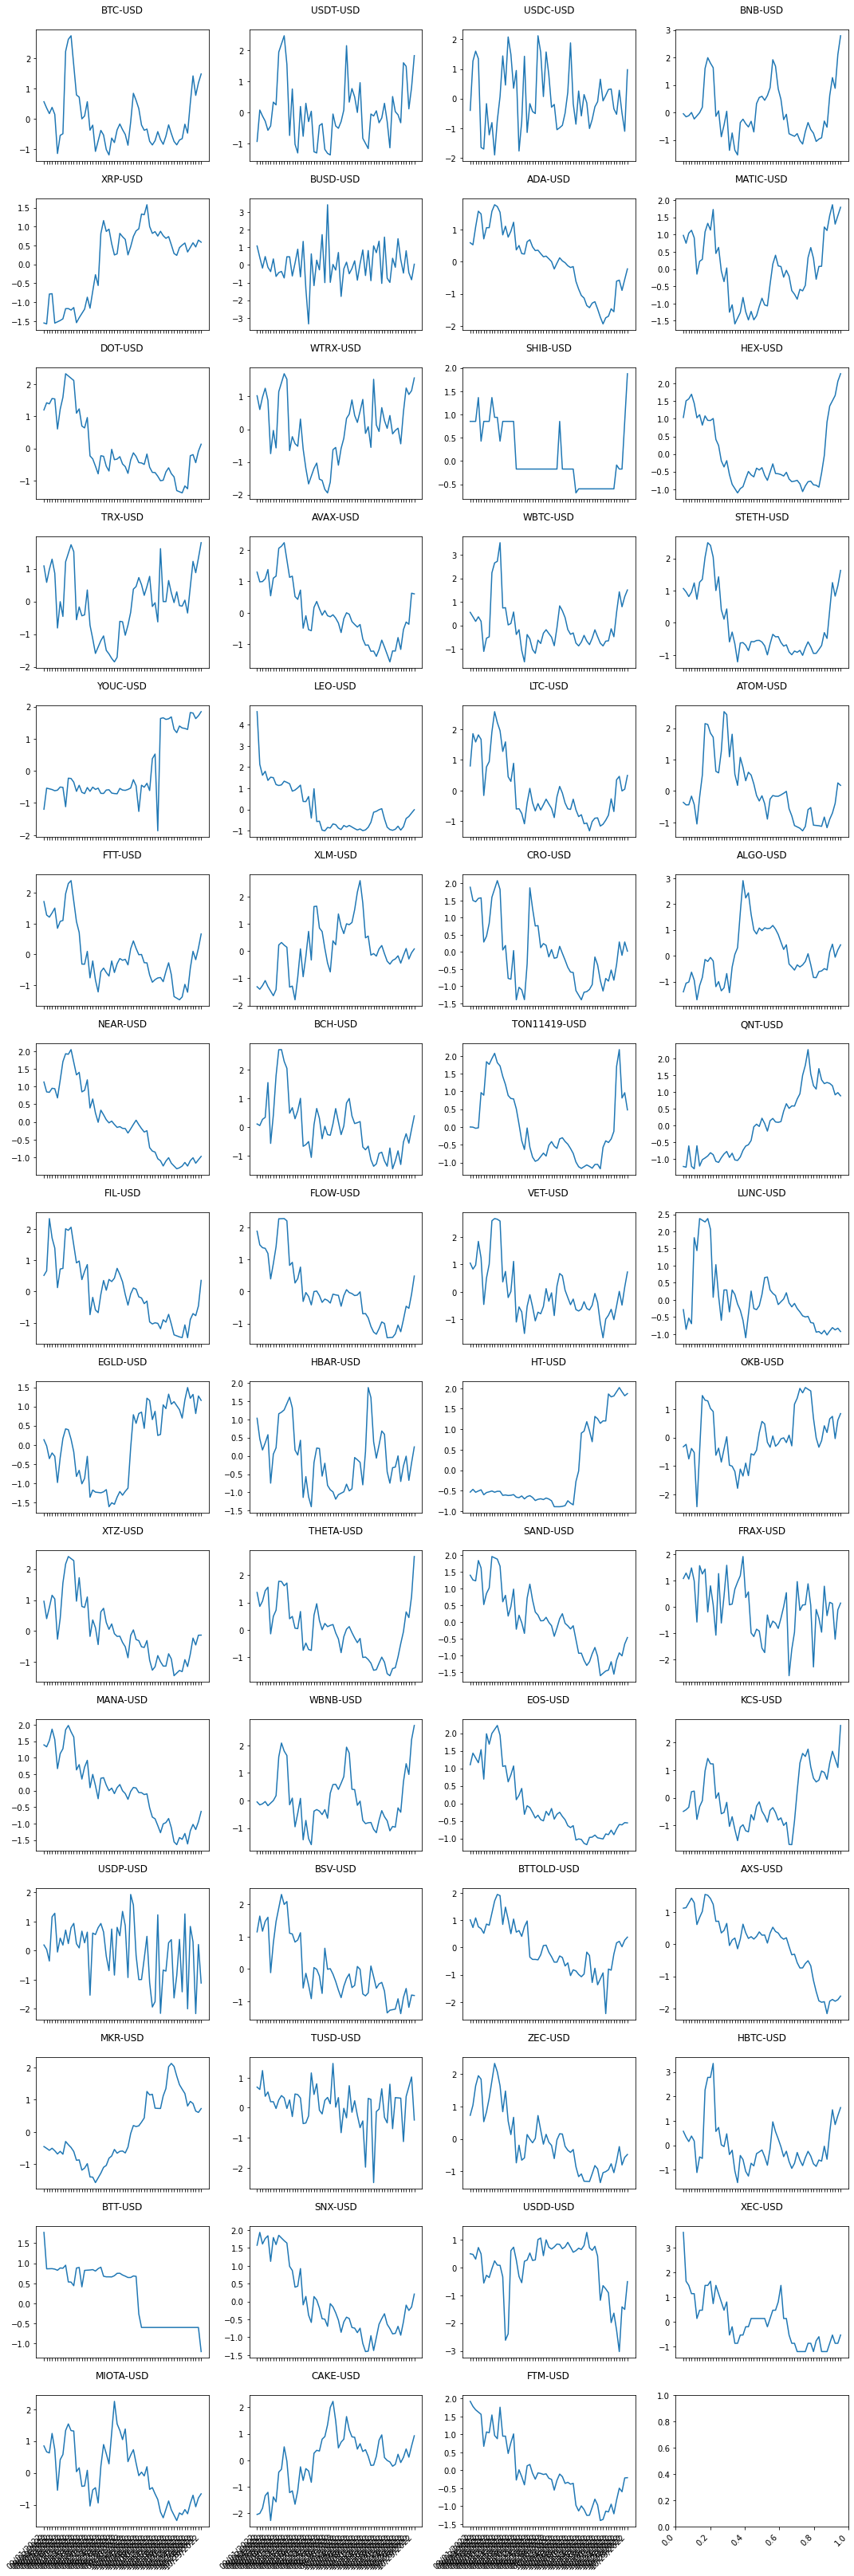

Cluster number1
------------------------------------------------------



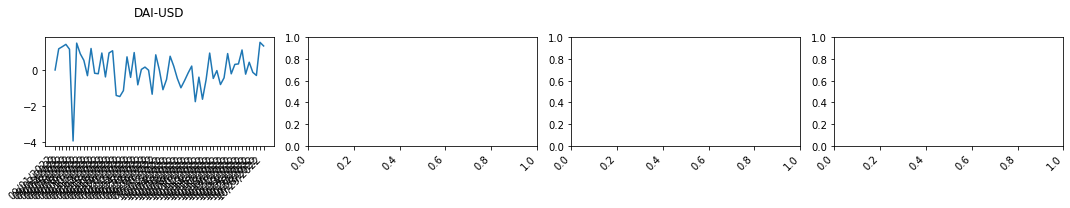

Cluster number2
------------------------------------------------------



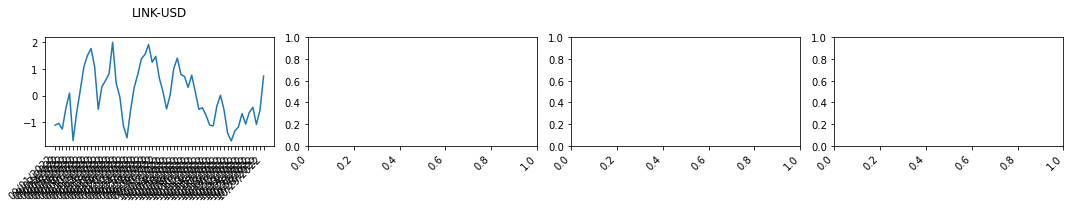

Cluster number3
------------------------------------------------------



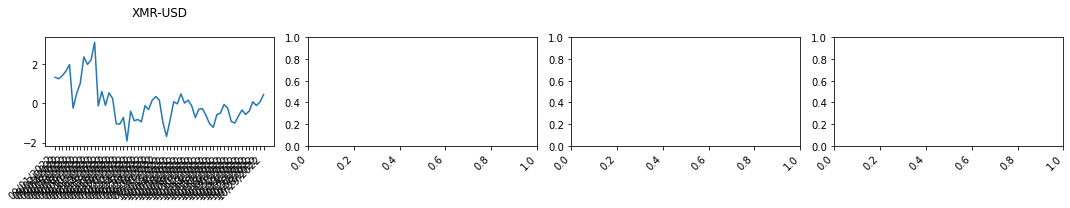

Cluster number4
------------------------------------------------------



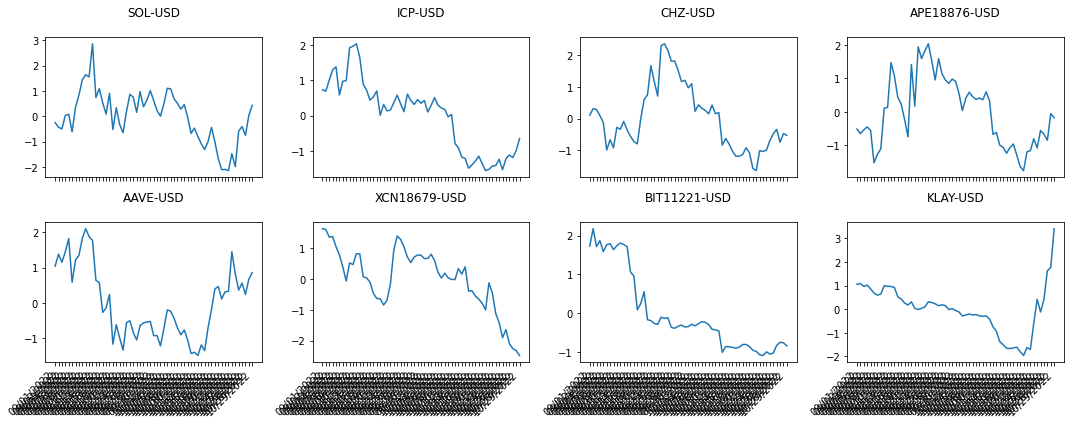

In [47]:
for cluster in range(5):
    print(f"Cluster number{cluster}")
    print("------------------------------------------------------\n")
    plot_cluster_tickers(df_eff[df_eff.cluster_eff == cluster])

Cluster number0
------------------------------------------------------



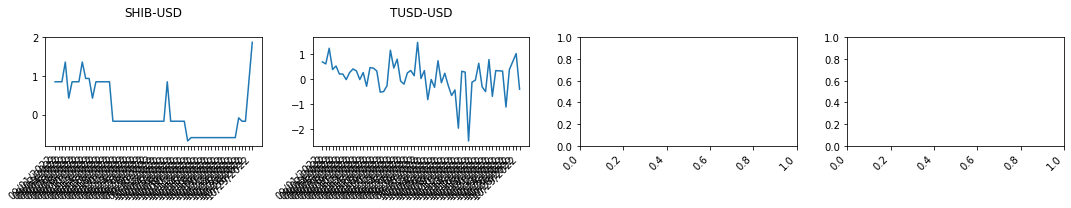

Cluster number1
------------------------------------------------------



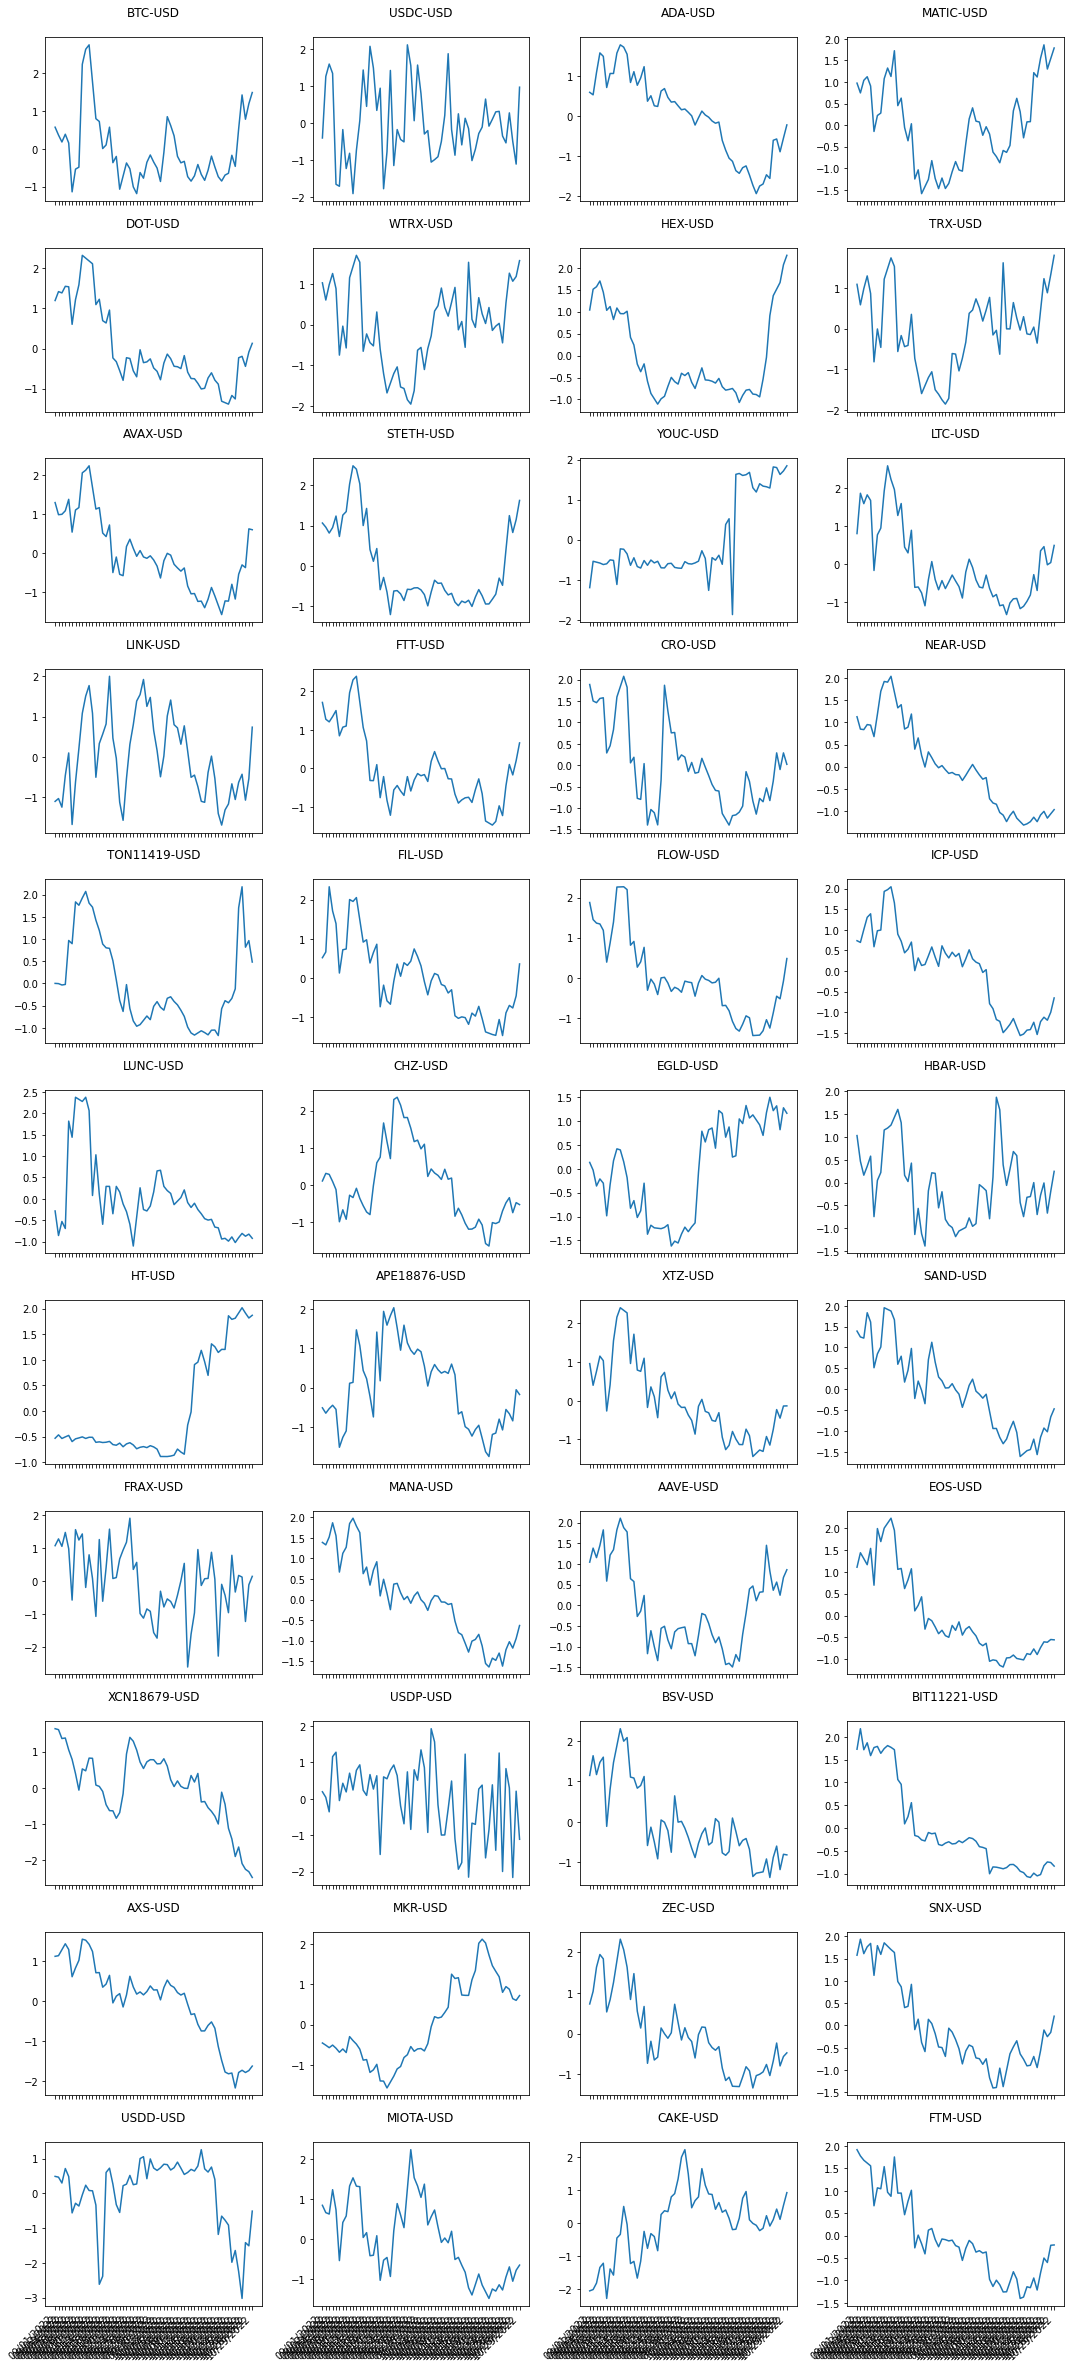

Cluster number2
------------------------------------------------------



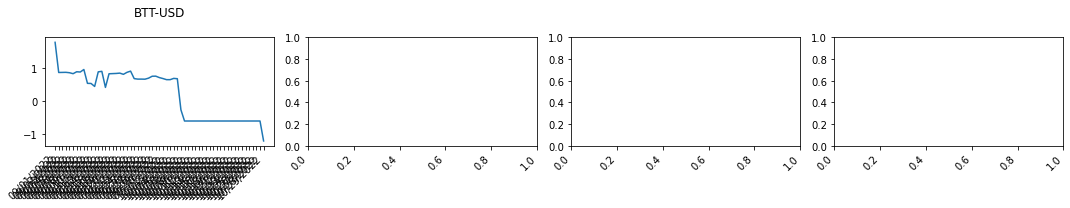

Cluster number3
------------------------------------------------------



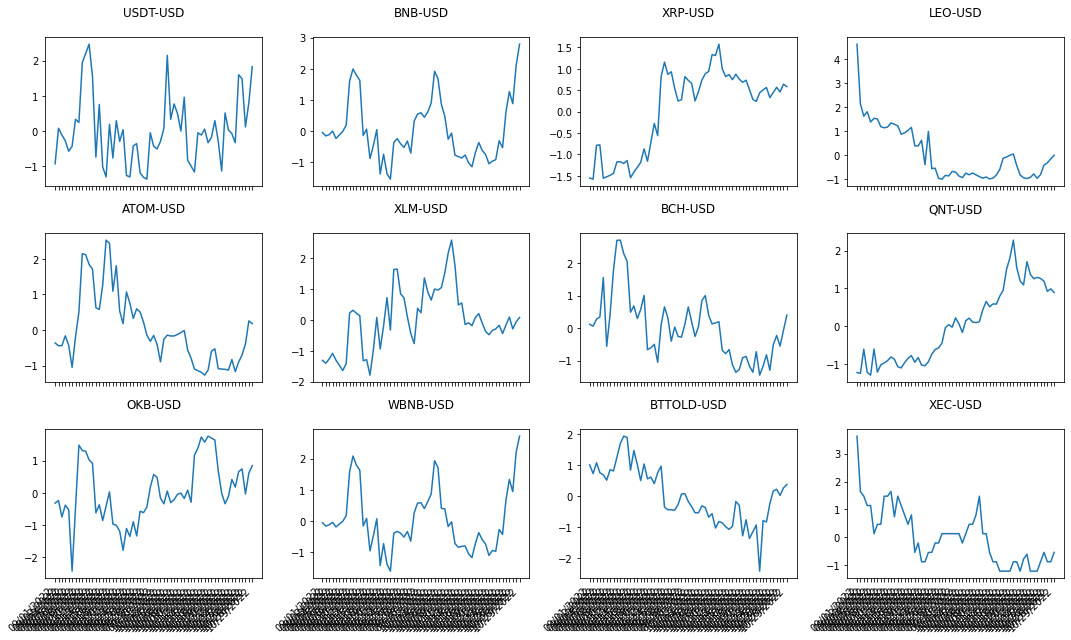

Cluster number4
------------------------------------------------------



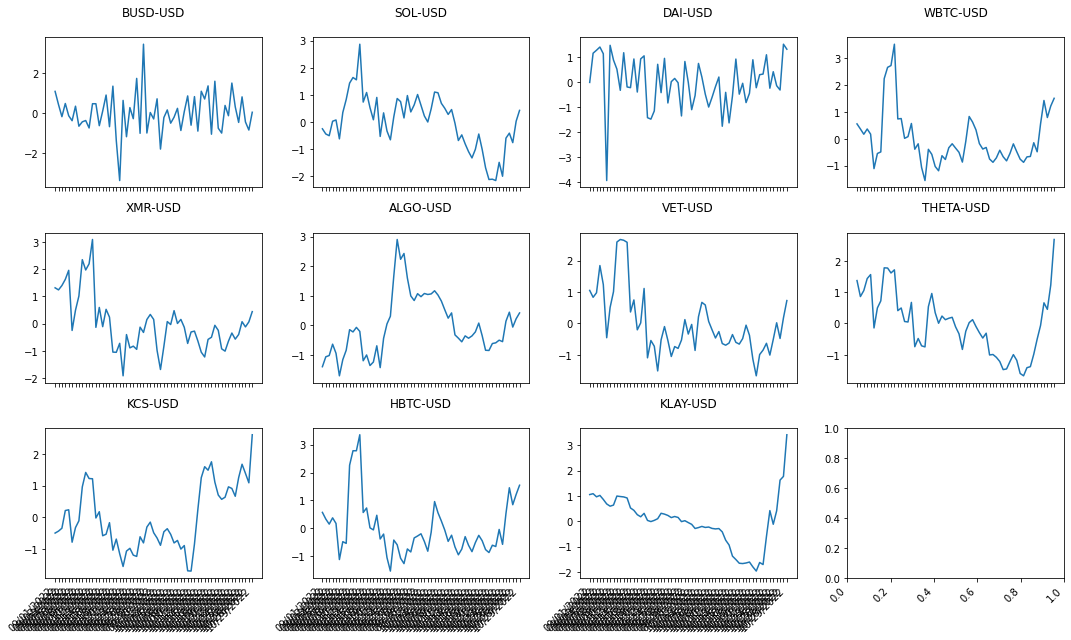

In [48]:
for cluster in range(5):
    print(f"Cluster number{cluster}")
    print("------------------------------------------------------\n")
    plot_cluster_tickers(df_min[df_min.cluster_min == cluster])

Аналитическая заметка: Данный датасет не использовался в предыдущих работах, в датасете ~ 70 различных криптовалют. Использовала цены закрытия. Перед кластеризацией отнормировала криптовалюты. Затем визуализировала аномалии и устранила их, поменяв аномальные значения на среднее между предыдущим и следующим днём, так как из-за аномальных точек кластеризация может пройти неправильного. Для начала сделала иерархическую кластеризацию, так как метод наиболее простой для реализации и визуально понятный. Для определения количества кластеров чаще всего используются методы "локоть" и "силуэт". Я пользовалась силуэтом, так как он более надёжный как метод. Так как датасет новый, то попробовала использовать и TimeSeriesKMeans с метрикой dtw и feature extraction. При использовании TimeSeriesKMeans с метрикой dtw получили очень маленькое значение силуэта для всех n от 2 до 10, что плохо.  
Feature extraction реализуем c помощью пакета tsfresh. Используем minimal и efficient настройки. При использовании feature extraction силуэт принимает и большие значения(близкие к 1), что хорошо. 
Если при использовании TSKM я могу уловить характерные черты каждого класса, то в классах, полученных с помощью Feature extraction, я этого сделать не могу. Не совсем понятно, почему это так